In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from imblearn.over_sampling import SMOTE
import gc
import tensorflow as tf
import absl.logging
from datetime import datetime
from scipy import stats

# Suppress warnings and set environment variables
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Ensure TensorFlow uses GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU available: ", physical_devices)
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except Exception as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU available, using CPU.")

No GPU available, using CPU.


In [ ]:
# Load data
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def preprocess_data(df, is_training=True, label_encoders=None):
    df = df.copy()

    # Original features
    numeric_cols = ['Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour']
    categorical_cols = ['Payment Method', 'Product Category', 'Customer Location', 'Device Used']

    # Handle missing values
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')

    # Advanced Feature Engineering

    # 1. Transaction Amount Features
    df['Amount_Log'] = np.log1p(df['Transaction Amount'])
    df['Amount_per_Quantity'] = df['Transaction Amount'] / (df['Quantity'] + 1)
    df['Amount_zscore'] = stats.zscore(df['Transaction Amount'], nan_policy='omit')

    # 2. Time-based Features
    df['Hour_Bin'] = pd.cut(df['Transaction Hour'], bins=[-np.inf, 6, 12, 18, np.inf], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    df['Is_Weekend'] = (pd.to_datetime(df['Transaction Date']).dt.dayofweek >= 5).astype(int)
    df['Day_of_Week'] = pd.to_datetime(df['Transaction Date']).dt.dayofweek

    # 3. Customer Profile Features
    df['Age_Category'] = pd.cut(df['Customer Age'], bins=[0, 25, 35, 50, 65, np.inf], labels=['Young', 'Young_Adult', 'Adult', 'Senior', 'Elder'])
    df['Account_Age_Weeks'] = df['Account Age Days'] // 7
    df['Is_New_Account'] = (df['Account Age Days'] <= 30).astype(int)

    # 4. Transaction Pattern Features
    df['Transaction_Size'] = pd.qcut(df['Transaction Amount'], q=5, labels=['Very_Small', 'Small', 'Medium', 'Large', 'Very_Large'], duplicates='drop')
    df['Quantity_Log'] = np.log1p(df['Quantity'])

    # 5. Location-Device Interaction
    df['Location_Device'] = df['Customer Location'] + '_' + df['Device Used']

    # 6. Risk Indicators
    df['High_Amount_Flag'] = (df['Transaction Amount'] > df['Transaction Amount'].quantile(0.95)).astype(int)
    df['High_Quantity_Flag'] = (df['Quantity'] > df['Quantity'].quantile(0.95)).astype(int)
    df['Unusual_Hour_Flag'] = ((df['Transaction Hour'] < 6) | (df['Transaction Hour'] > 22)).astype(int)

    # Handle categorical encoding
    if is_training:
        label_encoders = {}
        for col in categorical_cols + ['Hour_Bin', 'Age_Category', 'Transaction_Size', 'Location_Device']:
            if col in df.columns:
                label_encoders[col] = LabelEncoder()
                df[col] = label_encoders[col].fit_transform(df[col])
        return df, label_encoders
    else:
        for col in categorical_cols + ['Hour_Bin', 'Age_Category', 'Transaction_Size', 'Location_Device']:
            if col in df.columns and col in label_encoders:
                df[col] = df[col].map(lambda x: 'Unknown' if x not in label_encoders[col].classes_ else x)
                if 'Unknown' not in label_encoders[col].classes_:
                    label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'Unknown')
                df[col] = label_encoders[col].transform(df[col])
        return df


In [ ]:
# Handle imbalance
def handle_imbalance(X, y):
    print("Class distribution before SMOTE:")
    print(y.value_counts())

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("\nClass distribution after SMOTE:")
    print(y_resampled.value_counts())

    return X_resampled, y_resampled

In [ ]:
# Base Model Trainer
class BaseModelTrainer:
    def __init__(self):
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear'),
            'XGBoost': xgb.XGBClassifier(n_estimators=1000, max_depth=15, learning_rate=0.01, tree_method='hist', use_label_encoder=False)
        }
        self.best_models = {}

    def train(self, X_train, y_train):
        for model_name, model in self.models.items():
            model.fit(X_train, y_train)
            self.best_models[model_name] = model
            gc.collect()

    def evaluate(self, X_val, y_val):
        results = {}
        for model_name, model in self.best_models.items():
            y_pred = model.predict(X_val)
            y_prob = model.predict_proba(X_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, y_prob)
            roc_auc = auc(fpr, tpr)
            accuracy = accuracy_score(y_val, y_pred)
            precision = precision_score(y_val, y_pred)
            recall = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            confusion = confusion_matrix(y_val, y_pred)
            results[model_name] = {
                'ROC AUC': roc_auc,
                'Accuracy': accuracy,
                'F1 Score': f1,
                'Precision': precision,
                'Recall': recall,
                'y_prob': y_prob,
                'Confusion Matrix': confusion
            }
        return results

In [ ]:
# Neural Network Model
class NeuralNetworkModel:
    def __init__(self, input_dim):
        self.model = Sequential([
            Input(shape=(input_dim,)),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    def train(self, X_train, y_train, X_val, y_val):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.model.fit(X_train, y_train, epochs=200, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    def evaluate(self, X_val, y_val):
        y_prob = self.model.predict(X_val).flatten()
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        confusion = confusion_matrix(y_val, y_pred)
        return {
            'ROC AUC': roc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'y_prob': y_prob,
            'Confusion Matrix': confusion
        }

In [ ]:
# Ensemble Model
class EnsembleModel:
    def __init__(self, base_models, nn_model):
        self.base_models = base_models
        self.nn_model = nn_model
        self.weights = None

    def train(self, X_val, y_val):
        base_preds = np.column_stack([model.predict_proba(X_val)[:, 1] for model in self.base_models.values()])
        nn_preds = self.nn_model.model.predict(X_val).flatten()
        all_preds = np.column_stack([base_preds, nn_preds])

        # Use logistic regression to find optimal weights
        meta_model = LogisticRegression()
        meta_model.fit(all_preds, y_val)
        self.weights = meta_model.coef_[0] / np.sum(meta_model.coef_[0])

    def predict(self, X_val):
        base_preds = np.column_stack([model.predict_proba(X_val)[:, 1] for model in self.base_models.values()])
        nn_preds = self.nn_model.model.predict(X_val).flatten()
        all_preds = np.column_stack([base_preds, nn_preds])
        return np.dot(all_preds, self.weights)

    def evaluate(self, X_val, y_val):
        y_prob = self.predict(X_val)
        y_pred = (y_prob > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_val, y_prob)
        roc_auc = auc(fpr, tpr)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        confusion = confusion_matrix(y_val, y_pred)
        return {
            'ROC AUC': roc_auc,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'y_prob': y_prob,
            'Confusion Matrix': confusion
        }

In [ ]:
# Visualization function1
def plot_auc_roc_curve(models_results, nn_results, ensemble_results, y_val):
    plt.figure(figsize=(12, 8))

    for model_name, metrics in models_results.items():
        fpr, tpr, _ = roc_curve(y_val, metrics['y_prob'])
        plt.plot(fpr, tpr, label=f'{model_name} (AUC: {metrics["ROC AUC"]:.4f})')

    fpr, tpr, _ = roc_curve(y_val, nn_results['y_prob'])
    plt.plot(fpr, tpr, label=f'Neural Network (AUC: {nn_results["ROC AUC"]:.4f})', linestyle='-.')

    fpr, tpr, _ = roc_curve(y_val, ensemble_results['y_prob'])
    plt.plot(fpr, tpr, label=f'Ensemble Model (AUC: {ensemble_results["ROC AUC"]:.4f})', linestyle='--')

    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [ ]:
# Visualization function2
def plot_metrics(models_results, nn_results, ensemble_results):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

    # Accuracy
    ax1.bar(['Logistic Regression', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Accuracy'],
            models_results['XGBoost']['Accuracy'],
            nn_results['Accuracy'],
            ensemble_results['Accuracy']])
    ax1.set_title('Accuracy')

    # F1 Score
    ax2.bar(['Logistic Regression','XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['F1 Score'],
            models_results['XGBoost']['F1 Score'],
            nn_results['F1 Score'],
            ensemble_results['F1 Score']])
    ax2.set_title('F1 Score')

    # Precision
    ax3.bar(['Logistic Regression', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Precision'],
            models_results['XGBoost']['Precision'],
            nn_results['Precision'],
            ensemble_results['Precision']])
    ax3.set_title('Precision')

    # Recall
    ax4.bar(['Logistic Regression', 'XGBoost', 'Neural Network', 'Ensemble'],
           [models_results['Logistic Regression']['Recall'],
            models_results['XGBoost']['Recall'],
            nn_results['Recall'],
            ensemble_results['Recall']])
    ax4.set_title('Recall')

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
def plot_confusion_matrices(models_results, nn_results, ensemble_results):
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    models_list = ['Logistic Regression', 'XGBoost', 'Neural Network', 'Ensemble']
    results_list = [models_results, models_results, nn_results, ensemble_results]

    for i, (model_name, results) in enumerate(zip(models_list, results_list)):
        ax = axes[i // 3, i % 3]
        confusion = results[model_name]['Confusion Matrix'] if model_name in results else results['Confusion Matrix']
        im = ax.imshow(confusion, cmap='Blues')
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        # Annotate the confusion matrix
        for x in range(confusion.shape[0]):
            for y in range(confusion.shape[1]):
                ax.text(y, x, f'{confusion[x, y]}', ha='center', va='center', color='black')

        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data loaded successfully from /content/drive/MyDrive/Colab Notebooks/fraud/dataset e-commerce.csv
Data loaded successfully from /content/drive/MyDrive/Colab Notebooks/fraud/dataset e-commerce.csv
Class distribution before SMOTE:
Is Fraudulent
0    9506
1     494
Name: count, dtype: int64

Class distribution after SMOTE:
Is Fraudulent
0    9506
1    9506
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:27:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Base Model Results:
Logistic Regression:
  - ROC AUC: 0.9349
  - Accuracy: 0.8593
  - F1 Score: 0.8570
  - Precision: 0.8712
  - Recall: 0.8432
  - Confusion Matrix:
[[1665  237]
 [ 298 1603]]

XGBoost:
  - ROC AUC: 0.9947
  - Accuracy: 0.9734
  - F1 Score: 0.9731
  - Precision: 0.9865
  - Recall: 0.9600
  - Confusion Matrix:
[[1877   25]
 [  76 1825]]


Neural Network Results:
  - ROC AUC: 0.9921
  - Accuracy: 0.9613
  - F1 Score: 0.9610
  - Precision: 0.9700
  - Recall: 0.9521
  - Confusion Matrix:
[[1846   56]
 [  91 1810]]


Ensemble Model Results:
  - ROC AUC: 0.9950
  - Accuracy: 0.9755
  - F1 Score: 0.9753
  - Precision: 0.9860
  - Recall: 0.9648
  - Confusion Matrix:
[[1876   26]
 [  67 1834]]



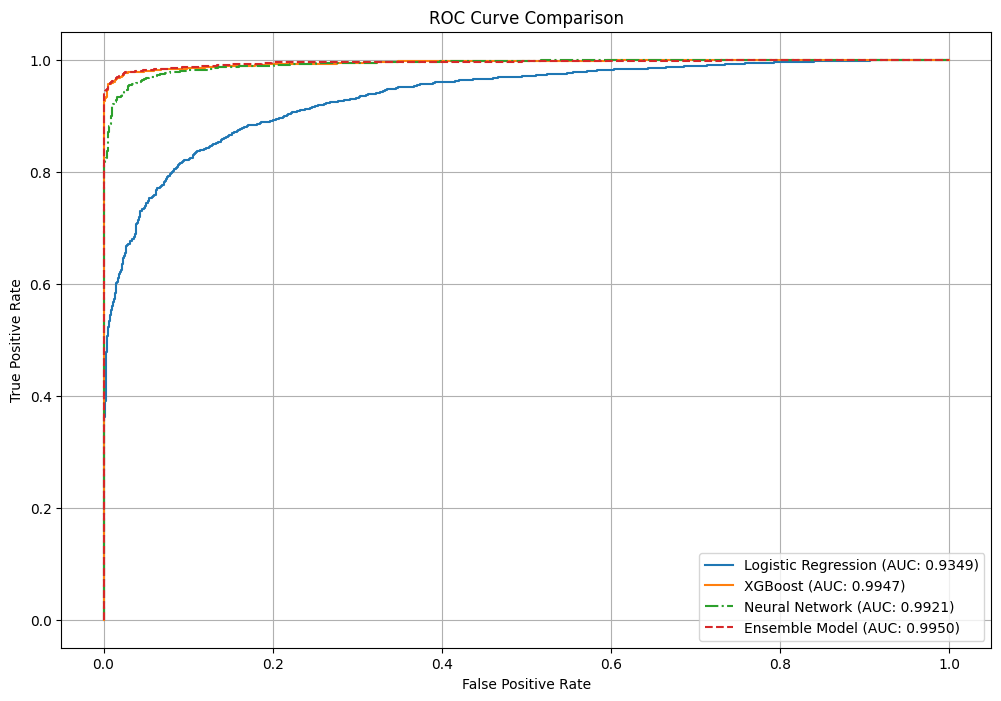

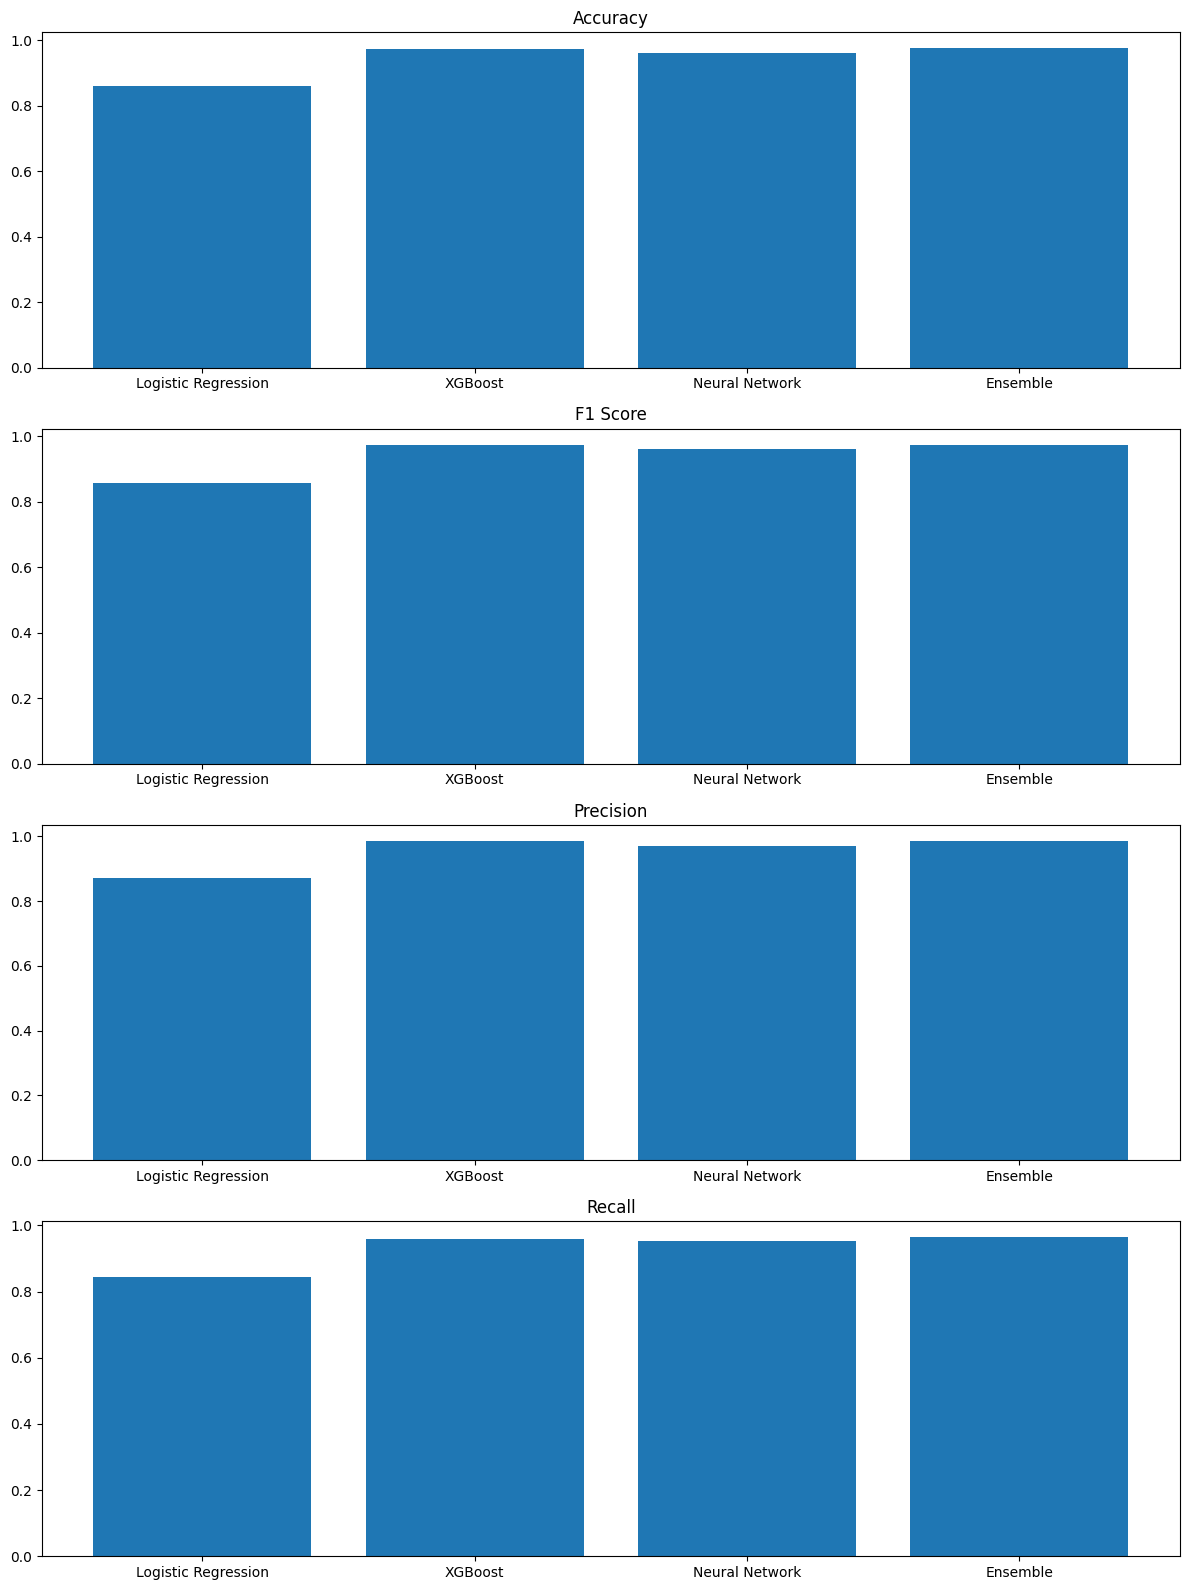

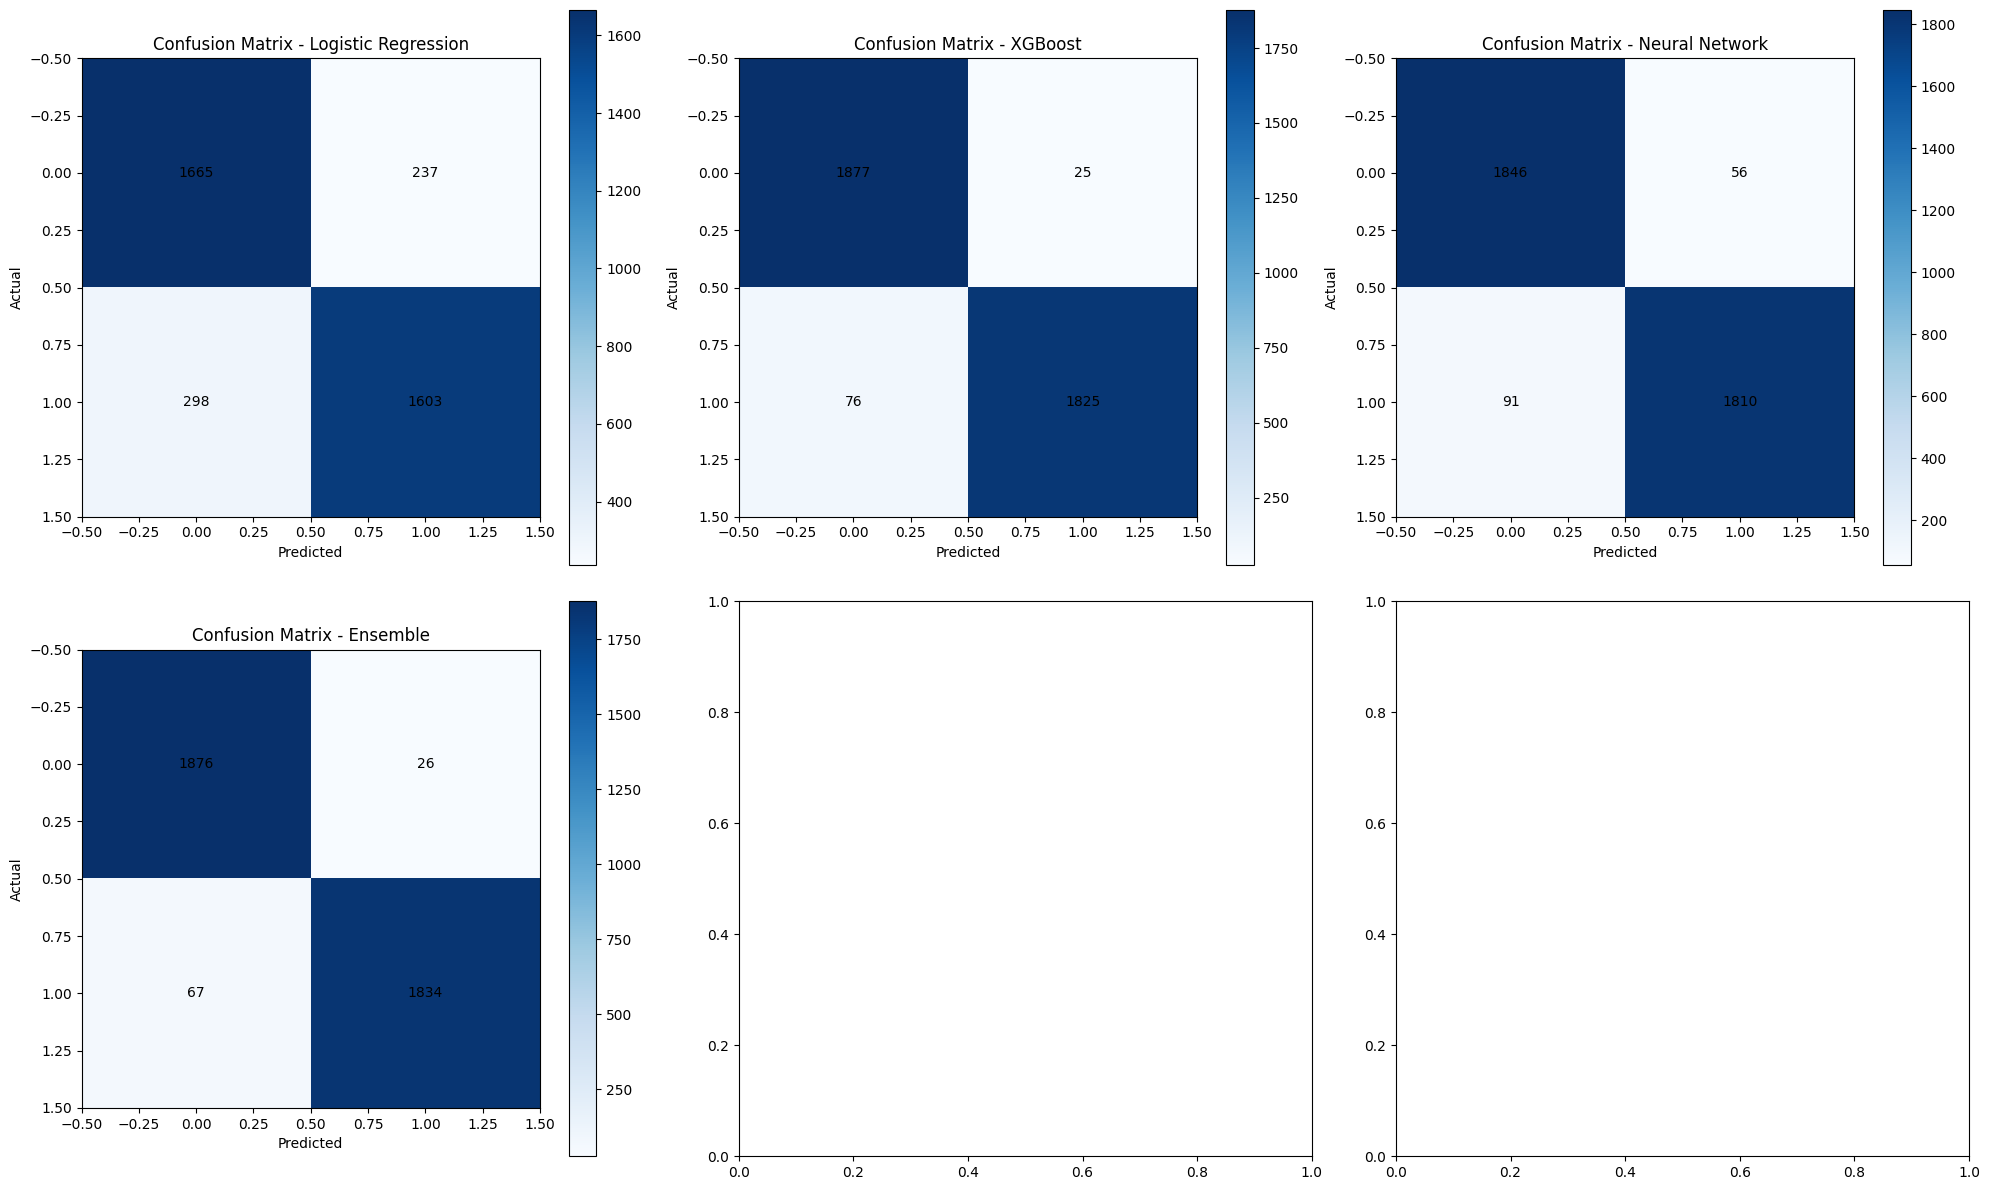

In [ ]:
# Run Pipeline
def run_pipeline(train_df, test_df):
    # Preprocess data
    train_df, label_encoders = preprocess_data(train_df, is_training=True)
    test_df = preprocess_data(test_df, is_training=False, label_encoders=label_encoders)

    # Define feature columns and target including new engineered features
    features = [
        # Original features
        'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days', 'Transaction Hour',
        'Payment Method', 'Product Category', 'Customer Location', 'Device Used',
        # Amount-based features
        'Amount_Log', 'Amount_per_Quantity', 'Amount_zscore',
        # Time-based features
        'Hour_Bin', 'Is_Weekend', 'Day_of_Week',
        # Customer profile features
        'Age_Category', 'Account_Age_Weeks', 'Is_New_Account',
        # Transaction pattern features
        'Transaction_Size', 'Quantity_Log',
        # Location-Device interaction
        'Location_Device',
        # Risk indicators
        'High_Amount_Flag', 'High_Quantity_Flag', 'Unusual_Hour_Flag'
    ]

    X = train_df[features]
    y = train_df['Is Fraudulent']

    # Handle class imbalance
    X_resampled, y_resampled = handle_imbalance(X, y)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train base models
    base_trainer = BaseModelTrainer()
    base_trainer.train(X_train_scaled, y_train)

    # Evaluate base models
    base_results = base_trainer.evaluate(X_val_scaled, y_val)

    # Train neural network model
    input_dim = X_train_scaled.shape[1]
    nn_model = NeuralNetworkModel(input_dim=input_dim)
    nn_model.train(X_train_scaled, y_train, X_val_scaled, y_val)

    # Evaluate neural network model
    nn_results = nn_model.evaluate(X_val_scaled, y_val)

    # Train and evaluate ensemble model
    ensemble_model = EnsembleModel(base_models=base_trainer.best_models, nn_model=nn_model)
    ensemble_model.train(X_val_scaled, y_val)
    ensemble_results = ensemble_model.evaluate(X_val_scaled, y_val)

    # Calculate feature importance

    # Print results
    print("\nBase Model Results:")
    for model_name, metrics in base_results.items():
        print(f"{model_name}:")
        print(f"  - ROC AUC: {metrics['ROC AUC']:.4f}")
        print(f"  - Accuracy: {metrics['Accuracy']:.4f}")
        print(f"  - F1 Score: {metrics['F1 Score']:.4f}")
        print(f"  - Precision: {metrics['Precision']:.4f}")
        print(f"  - Recall: {metrics['Recall']:.4f}")
        print(f"  - Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

    print("\nNeural Network Results:")
    print(f"  - ROC AUC: {nn_results['ROC AUC']:.4f}")
    print(f"  - Accuracy: {nn_results['Accuracy']:.4f}")
    print(f"  - F1 Score: {nn_results['F1 Score']:.4f}")
    print(f"  - Precision: {nn_results['Precision']:.4f}")
    print(f"  - Recall: {nn_results['Recall']:.4f}")
    print(f"  - Confusion Matrix:\n{nn_results['Confusion Matrix']}\n")

    print("\nEnsemble Model Results:")
    print(f"  - ROC AUC: {ensemble_results['ROC AUC']:.4f}")
    print(f"  - Accuracy: {ensemble_results['Accuracy']:.4f}")
    print(f"  - F1 Score: {ensemble_results['F1 Score']:.4f}")
    print(f"  - Precision: {ensemble_results['Precision']:.4f}")
    print(f"  - Recall: {ensemble_results['Recall']:.4f}")
    print(f"  - Confusion Matrix:\n{ensemble_results['Confusion Matrix']}\n")

    # Plot AUC-ROC comparison
    plot_auc_roc_curve(base_results, nn_results, ensemble_results, y_val)

    # Plot Metrics Comparison
    plot_metrics(base_results, nn_results, ensemble_results)

    # Plot Confusion Matrices
    plot_confusion_matrices(base_results, nn_results, ensemble_results)


# Path usage
train_df = load_data('/content/drive/MyDrive/Colab Notebooks/fraud/dataset e-commerce.csv')
test_df = load_data('/content/drive/MyDrive/Colab Notebooks/fraud/dataset e-commerce.csv')


if train_df is not None and test_df is not None:
    run_pipeline(train_df, test_df)